*in progress*

# Imports

In [20]:
# base
import math
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

# Data

In [6]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)
n, p = genotypes.shape

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 41.39it/s]


# Fit

In [14]:
D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / p
coord_rad = coord[:,::-1] * math.pi / 180.0
D_geo = haversine_distances(coord_rad) * 6371000/1000
tril_idx = np.tril_indices(n, k=-1)
x = D_geo[tril_idx]
y = D_geno[tril_idx]
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1804.
Date:                Sun, 02 May 2021   Prob (F-statistic):               0.00
Time:                        18:43:54   Log-Likelihood:                 8272.1
No. Observations:                6105   AIC:                        -1.654e+04
Df Residuals:                    6103   BIC:                        -1.653e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7405      0.002    440.451      0.0

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=5.4555900, alpha=0.8354260, converged in 66 iterations, train_loss=2774513.8908248


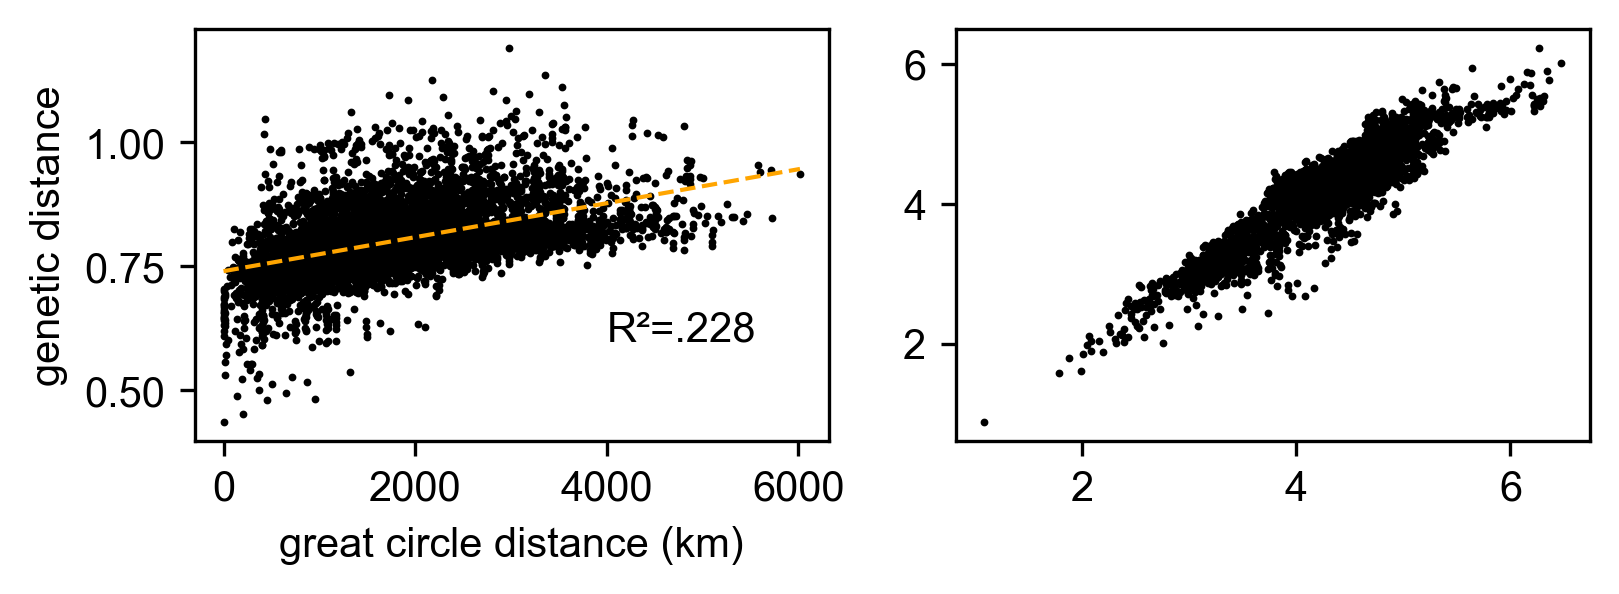

In [56]:
def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

muhat, betahat = res.params
ax_00 = fig.add_subplot(spec[0, 0])
ax_00.scatter(x, 
           y, 
           marker=".", 
           alpha=1, 
           zorder=0, 
           color="black",
           s=3)

x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1)
ax_00.set_xlabel("great circle distance (km)");
ax_00.set_ylabel("genetic distance");
ax_00.text(4000, .6, "R²=.228");

# TODO: in progress

tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
ax_01 = fig.add_subplot(spec[0, 1])
sp_graph.fit(lamb=5.45559,
             lb=math.log(1e-6), 
             ub=math.log(1e+6))
sp_graph.comp_graph_laplacian(sp_graph.w)
sp_graph.comp_graph_laplacian(sp_graph.w)
obj = Objective(sp_graph)
fit_cov, _, emp_cov = comp_mats(obj)
ax_01.scatter(cov_to_dist(fit_cov)[tril_idx], 
              cov_to_dist(emp_cov)[tril_idx], 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="black",
              s=3)